## model: godzina - dzien tygodnia

### getting demand data

In [92]:
import pandas as pd
from datetime import date
import datetime
import numpy as np
from dateutil.relativedelta import relativedelta
from matplotlib import pyplot as plt

weather_start_year = 2014
end_dt = '2019-03-31'
# 2 months:
start_dt = '2019-02-01'

#6 months:
# start_dt = '2018-10-01'

# 12 months:
# start_dt = '2018-04-01'

# #24 months:
# start_dt = '2017-04-01'

# # #60 months:
# start_dt = '2014-04-01'

weekdays =['Pon', 'Wt', 'Sr', 'Czw', 'Pt', 'Sb', 'Nd']

def dzienTyg(dzienNum):
    if dzienNum == 0:
        return 'Pon'
    elif dzienNum == 1:
        return 'Wt'
    elif dzienNum == 2:
        return 'Sr'
    elif dzienNum == 3:
        return 'Czw'
    elif dzienNum == 4:
        return 'Pt'
    elif dzienNum == 5:
        return 'Sb'
    elif dzienNum == 6:
        return 'Nd'
    else:
        return 'Blad'
def date_fromisofromat(dt):
    y = int(dt[0: 4])
    m = int(dt[5: 7])
    d = int(dt[8:10])
    return date(y,m,d)

def combineData(start, end):
    startDt = date_fromisofromat(start)
    endDt   = date_fromisofromat(end)
    d = datetime.timedelta(days=1)
    m = relativedelta(months=+1)

    in_table = pd.read_csv(filepath_or_buffer= '../../Data/20100301-20100331.csv', 
                       sep=';', 
                       engine='python')
    in_table= in_table.iloc[0:0] #drop all rows, leave columns

    while(startDt <= endDt):
        fileName = str(startDt).replace('-','') + '-' + str(startDt + m - d).replace('-','') + '.csv'
        in_table1 = pd.read_csv(filepath_or_buffer= '../../Data/' +fileName, 
                           sep=';', 
                           engine='python')
        in_table = in_table.append(in_table1,ignore_index=True)
        startDt = startDt + relativedelta(months=+1)

    in_table['Krajowe zapotrzebowanie na moc'] = in_table['Krajowe zapotrzebowanie na moc'].apply(lambda x: x.replace(',','.'))
    in_table['Krajowe zapotrzebowanie na moc'] = in_table['Krajowe zapotrzebowanie na moc'].astype(float)
    in_table['Rok']     = in_table['Data'].apply(lambda x: x[0: 4]).astype(int)
    in_table['Miesiac'] = in_table['Data'].apply(lambda x: x[5: 7]).astype(int)
    in_table['Dzien']   = in_table['Data'].apply(lambda x: x[8:10]).astype(int)
    # in_table['Godz_mies']=(in_table['Dzien']-1)*24 +in_table['Godzina']
    return in_table
#     plt.show()
# Data, Godzina, Krajowe zapotrzebowanie na moc, Sumaryczna generacja JWCD, 
# Generacja PI, Generacja IRZ, Sumaryczna generacja nJWCD, 
# Krajowe saldo wymiany międzysystemowej równoległej, 
# Krajowe saldo wymiany międzysystemowej nierównoległej, 

dataAll = combineData(start_dt, end_dt)
dataAll = dataAll.loc[dataAll['Godzina'] != '2A']

dataAll['Godzina'] = dataAll['Godzina'].apply(
    lambda x: (int(str(x)))
)
dataAll['weekDayNum'] = dataAll['Data'].apply(
    lambda x: (date_fromisofromat(x).weekday())
)
dataAll['weekDay'] = dataAll['Data'].apply(
    lambda x: dzienTyg(date_fromisofromat(x).weekday())
)
dataAll['DataGodz'] = pd.to_datetime(dataAll['Data']) 

dataAll['DataGodz'] = dataAll['DataGodz'] + dataAll['Godzina'].apply(
    lambda x: relativedelta(hours=x)
)
    
modelData = dataAll[['Krajowe zapotrzebowanie na moc']]

#For Arima:
modelData2 = dataAll[['Krajowe zapotrzebowanie na moc',
                      'DataGodz']] 
modelData2.set_index('DataGodz')
modelData2.index = pd.DatetimeIndex(modelData2['DataGodz'])#.to_period('H')

modelData2

D:\Programy\anaconda\lib\site-packages\pandas\core\arrays\datetimelike.py:1345: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized
  PerformanceWarning,


,Krajowe zapotrzebowanie na moc,DataGodz
DataGodz,,
2019-02-01 01:00:00,18765.913,2019-02-01 01:00:00
2019-02-01 02:00:00,18248.625,2019-02-01 02:00:00
2019-02-01 03:00:00,17886.125,2019-02-01 03:00:00
2019-02-01 04:00:00,17820.938,2019-02-01 04:00:00
2019-02-01 05:00:00,18178.363,2019-02-01 05:00:00
...,...,...
2019-03-31 20:00:00,18097.938,2019-03-31 20:00:00
2019-03-31 21:00:00,18774.000,2019-03-31 21:00:00
2019-03-31 22:00:00,17979.813,2019-03-31 22:00:00


In [93]:
dataAll
#For Arima:
modelData2 = dataAll[['Krajowe zapotrzebowanie na moc',
                      'DataGodz','weekDay']] 
# modelData2.set_index('DataGodz')
# modelData2.index = pd.DatetimeIndex(modelData2['DataGodz'])#.to_period('H')

In [3]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

from statsmodels.tsa.seasonal import seasonal_decompose
def create_model(dane, sezon, maxiter = 20, regresor = None):
    start = datetime.datetime.now()

    #auto ARIMA
    m = auto_arima(dane, 
           seasonal = True, 
           m=sezon, 
           maxiter = maxiter,
           trace = True,
           exogenous = regresor)#.summary()
    print('autoARIMA time: ' + str(datetime.datetime.now() - start))
    order = m.get_params()['order']
    seasonal_order = m.get_params()['seasonal_order']
    print(order)
    print(seasonal_order)
    #SARIMAX
    fit_start =  datetime.datetime.now()
    model = SARIMAX(dane, order=order, seasonal_order=seasonal_order, initialization='approximate_diffuse',exog = regresor)
    model_fit = model.fit() 
    
    print('fit time = ' + str(datetime.datetime.now() - fit_start))
    return model_fit

### Getting weather data

In [4]:
weather_cols = [
'Kod stacji'
,'Nazwa stacji'
,'Rok' 
,'Miesiąc' 
,'Dzień'
,'Godzina' 
,'Wysokość podstawy chmur CL CM szyfrowana [kod]'
,'Status pomiaru HPOD' 
,'Wysokość podstawy niższej  [m]'
,'Status pomiaru HPON' 
,'Wysokość podstawy wyższej [m]'
,'Status pomiaru HPOW' 
,'Wysokość podstawy tekstowy [opis]' 
,'Pomiar przyrzadem 1 (niższa) [P]'
,'Pomiar przyrzadem 2 (wyższa) [P]'
,'Widzialność  [kod]' 
,'Satus pomiaru WID' 
,'Widzialność operatora [m]' 
,'Status pomiaru WIDO' 
,'Widzialność automat [m]'
,'Status pomiaru WIDA' 
,'Zachmurzenie ogólne [oktanty]'
,'Status pomiaru NOG'  
,'Kierunek wiatru  [°]'
,'Status pomiaru KRWR' 
,'Prędkość wiatru  [m/s]' ######################################
,'Status pomiaru FWR'  
,'Poryw wiatru  [m/s]' 
,'Status pomiaru PORW' 
,'Temperatura powietrza [°C]' ######################################
,'Status pomiaru TEMP' 
,'Temperatura termometru zwilżonego [°C]'
,'Status pomiaru TTZW' 
,'Wskaźnik wentylacji [W/N]' 
,'Wskaźnik lodu [L/W]' 
,'Ciśnienie pary wodnej [hPa]'  
,'Status pomiaru CPW'  
,'Wilgotność względna [%]'
,'Status pomiaru WLGW' 
,'Temperatura punktu rosy [°C]' 
,'Status pomiaru TPTR' 
,'Ciśnienie na pozimie stacji [hPa]'  
,'Status pomiaru PPPS' 
,'Ciśnienie na pozimie morza [hPa]'
,'Status pomiaru PPPM' 
,'Charakterystyka tendencji [kod]' 
,'Wartość tendencji [wartość]'  
,'Status pomiaru APP'  
,'Opad za 6 godzin [mm]'  
,'Status pomiaru WO6G'
,'Rodzaj opadu za 6 godzin [kod]'
,'Status pomiaru ROPT'
,'Pogoda bieżąca [kod]'
,'Pogoda ubiegła [kod]'
,'Zachmurzenie niskie [oktanty]'
,'Status pomiaru CLCM'
,'Chmury CL [kod]'
,'Status pomiaru CHCL'
,'Chmury CL tekstem'
,'Chmury CM [kod]'
,'Status pomiaru CHCM'
,'Chmury CM tekstem'
,'Chmury CH [kod]'
,'Status pomiaru CHCH'
,'Chmury CH tekstem'
,'Stan gruntu [kod]'
,'Status pomiaru SGRN'
,'Niedosyt wilgotności [hPa}'
,'Status pomiaru DEFI'
,'Usłonecznienie'
,'Status pomiaru USLN'
,'Wystąpienie rosy [0/1]'
,'Status pomiaru ROSW'
,'Poryw maksymalny za okres WW [m/s]'
,'Status pomiaru PORK'
,'Godzina wystąpienia porywu'
,'Minuta wystąpienia porywu'
,'Temperatura gruntu -5 [°C]'
,'Status pomiaru TG05'
,'Temperatura gruntu -10 [°C]'
,'Status pomiaru TG10'
,'Temperatura gruntu -20 [°C]'
,'Status pomiaru TG20'
,'Temperatura gruntu -50 [°C]'
,'Status pomiaru TG50'
,'Temperatura gruntu -100 [°C]'
,'Status pomiaru TG100'
,'Temperatura minimalna za 12 godzin  [°C]'
,'Status pomiaru TMIN'
,'Temperatura maksymalna za 12 godzin [°C]'
,'Status pomiaru TMAX'
,'Temperatura minimalna przy gruncie za 12 godzin [°C]'
,'Status pomiaru TGMI'
,'Równoważnik wodny śniegu [mm/cm]'
,'Status pomiaru RWSN'
,'Wysokość pokrywy śnieżnej [cm]'
,'Status pomiaru PKSN'
,'Wysokość świeżo spadłego śniegu  [cm]'
,'Status pomiaru HSS'
,'Wysokość śniegu na poletku [cm]'
,'Status pomiaru GRSN'
,'Gatunek śniegu  [kod]'
,'Ukształtowanie pokrywy [kod]'
,'Wysokość próbki [cm]'
,'Status pomiaru HPRO'
,'Ciężar próbki [g]'
,'Status pomiaru CIPR'
]

In [5]:
def readWeatherFile(file_name):
    file = '../../Additional Data/Weather/' + file_name
    df = pd.read_csv(filepath_or_buffer = file
                     ,engine='python'
                     ,sep = ','
                     ,header = None
                    )

    df.columns = weather_cols
    return df
# test:
# readWeatherFile('s_t_690_2017.csv')

In [6]:
# getting list of s_d_t .csv files

import glob
file_names_list = (glob.glob("..\\..\\Additional Data\\Weather\\s_t_*.csv"))
lst=[]

for file_name in file_names_list:
    file_name = file_name[-16:]
    file_name = file_name.replace("\\","")
    lst.append(file_name)
#     print(file_name)
file_names_list = lst
lst=[]

In [7]:
names_to_drop=[]
for i in file_names_list:
    if(int(i[-8:-4]) < weather_start_year):
        names_to_drop.append(i)
for i in names_to_drop:
    file_names_list.remove(i)
file_names_list

['s_t_01_2020.csv',
 's_t_02_2020.csv',
 's_t_03_2020.csv',
 's_t_04_2020.csv',
 's_t_05_2020.csv',
 's_t_06_2020.csv',
 's_t_07_2020.csv',
 's_t_08_2020.csv',
 's_t_09_2020.csv',
 's_t_100_2014.csv',
 's_t_100_2015.csv',
 's_t_100_2016.csv',
 's_t_100_2017.csv',
 's_t_100_2018.csv',
 's_t_100_2019.csv',
 's_t_100_2020.csv',
 's_t_105_2014.csv',
 's_t_105_2015.csv',
 's_t_105_2016.csv',
 's_t_105_2017.csv',
 's_t_105_2018.csv',
 's_t_105_2019.csv',
 's_t_105_2020.csv',
 's_t_10_2020.csv',
 's_t_115_2014.csv',
 's_t_115_2015.csv',
 's_t_115_2016.csv',
 's_t_115_2017.csv',
 's_t_115_2018.csv',
 's_t_115_2019.csv',
 's_t_115_2020.csv',
 's_t_120_2014.csv',
 's_t_120_2015.csv',
 's_t_120_2016.csv',
 's_t_120_2017.csv',
 's_t_120_2018.csv',
 's_t_120_2019.csv',
 's_t_120_2020.csv',
 's_t_125_2014.csv',
 's_t_125_2015.csv',
 's_t_125_2016.csv',
 's_t_125_2017.csv',
 's_t_125_2018.csv',
 's_t_125_2019.csv',
 's_t_125_2020.csv',
 's_t_135_2014.csv',
 's_t_135_2015.csv',
 's_t_135_2016.csv',
 '

In [8]:
weatherDF = readWeatherFile(file_names_list[1]).iloc[0:0] #dummy
weatherDF = weatherDF[['Nazwa stacji'
            ,'Rok' 
            ,'Miesiąc' 
            ,'Dzień'
            ,'Godzina' 
            ,'Prędkość wiatru  [m/s]'
            ,'Temperatura powietrza [°C]']]
for file_name in file_names_list:
    weatherDF = weatherDF.append(
        readWeatherFile(file_name)[['Nazwa stacji'
            ,'Rok' 
            ,'Miesiąc' 
            ,'Dzień'
            ,'Godzina' 
            ,'Prędkość wiatru  [m/s]'
            ,'Temperatura powietrza [°C]']]
        ,ignore_index=True
        )
    print(file_name)
weatherDF.isna().sum()

s_t_01_2020.csv
s_t_02_2020.csv
s_t_03_2020.csv
s_t_04_2020.csv
s_t_05_2020.csv
s_t_06_2020.csv
s_t_07_2020.csv
s_t_08_2020.csv
s_t_09_2020.csv
s_t_100_2014.csv
s_t_100_2015.csv
s_t_100_2016.csv
s_t_100_2017.csv
s_t_100_2018.csv
s_t_100_2019.csv
s_t_100_2020.csv
s_t_105_2014.csv
s_t_105_2015.csv
s_t_105_2016.csv
s_t_105_2017.csv
s_t_105_2018.csv
s_t_105_2019.csv
s_t_105_2020.csv
s_t_10_2020.csv
s_t_115_2014.csv
s_t_115_2015.csv
s_t_115_2016.csv
s_t_115_2017.csv
s_t_115_2018.csv
s_t_115_2019.csv
s_t_115_2020.csv
s_t_120_2014.csv
s_t_120_2015.csv
s_t_120_2016.csv
s_t_120_2017.csv
s_t_120_2018.csv
s_t_120_2019.csv
s_t_120_2020.csv
s_t_125_2014.csv
s_t_125_2015.csv
s_t_125_2016.csv
s_t_125_2017.csv
s_t_125_2018.csv
s_t_125_2019.csv
s_t_125_2020.csv
s_t_135_2014.csv
s_t_135_2015.csv
s_t_135_2016.csv
s_t_135_2017.csv
s_t_135_2018.csv
s_t_135_2019.csv
s_t_135_2020.csv
s_t_155_2014.csv
s_t_155_2015.csv
s_t_155_2016.csv
s_t_155_2017.csv
s_t_155_2018.csv
s_t_155_2019.csv
s_t_155_2020.csv
s_t_160

Nazwa stacji                  0
Rok                           0
Miesiąc                       0
Dzień                         0
Godzina                       0
Prędkość wiatru  [m/s]        0
Temperatura powietrza [°C]    0
dtype: int64

In [9]:
weatherDF['Nazwa stacji'].unique()

array(['BIELSKO-BIAŁA', 'ZAKOPANE', 'KASPROWY WIERCH', 'HALA GĄSIENICOWA',
       'NOWY SĄCZ', 'KROSNO', 'LESKO', 'JELENIA GÓRA', 'ŚNIEŻKA',
       'KŁODZKO', 'OPOLE', 'RACIBÓRZ', 'CZĘSTOCHOWA',
       'KATOWICE-MUCHOWIEC', 'KRAKÓW-BALICE', 'KIELCE-SUKÓW', 'TARNÓW',
       'SANDOMIERZ', 'RZESZÓW-JASIONKA', 'ZAMOŚĆ', 'ZIELONA GÓRA',
       'LEGNICA', 'LESZNO', 'WROCŁAW-STRACHOWICE', 'KALISZ', 'WIELUŃ',
       'ŁÓDŹ-LUBLINEK', 'SULEJÓW', 'KOZIENICE', 'LUBLIN-RADAWIEC',
       'WŁODAWA', 'SŁUBICE', 'GORZÓW WIELKOPOLSKI', 'POZNAŃ-ŁAWICA',
       'KOŁO', 'PŁOCK', 'WARSZAWA-OKĘCIE', 'SIEDLCE', 'TERESPOL',
       'ŚWINOUJŚCIE', 'SZCZECIN', 'RESKO-SMÓLSKO', 'PIŁA', 'CHOJNICE',
       'TORUŃ', 'MŁAWA', 'OLSZTYN', 'MIKOŁAJKI', 'BIAŁYSTOK',
       'KOŁOBRZEG-DŹWIRZYNO', 'KOSZALIN', 'USTKA', 'ŁEBA', 'LĘBORK',
       'HEL', 'GDAŃSK-ŚWIBNO', 'ELBLĄG-MILEJEWO', 'KĘTRZYN', 'SUWAŁKI',
       'KOŁOBRZEG', 'POZNAŃ', 'WARSZAWA', 'WROCŁAW', 'ŁÓDŹ', 'KATOWICE'],
      dtype=object)

In [10]:
#wybranie top6 zaludnionych
# weatherDF = weatherDF[weatherDF['Nazwa stacji'].isin(
# ['WARSZAWA-OKĘCIE'
# ,'WROCŁAW-STRACHOWICE'
# ,'KRAKÓW-BALICE'
# ,'ŁÓDŹ-LUBLINEK'
# ,'GDAŃSK-ŚWIBNO'
# ,'POZNAŃ-ŁAWICA'
# ])]

In [11]:
#wywalenie odstających
weatherDF = weatherDF[~weatherDF['Nazwa stacji'].isin(
[
#     'WARSZAWA-OKĘCIE'
# ,'WROCŁAW-STRACHOWICE'
# ,'KRAKÓW-BALICE'
# ,'ŁÓDŹ-LUBLINEK'
# ,'GDAŃSK-ŚWIBNO'
# ,'POZNAŃ-ŁAWICA'
    'KASPROWY WIERCH',
    'ŚNIEŻKA',
    'ZAKOPANE'
])]

In [12]:
weatherByStation = weatherDF[
            ['Nazwa stacji',
           'Prędkość wiatru  [m/s]',
           'Temperatura powietrza [°C]']
         ].groupby('Nazwa stacji').mean()

<AxesSubplot:xlabel='Nazwa stacji'>

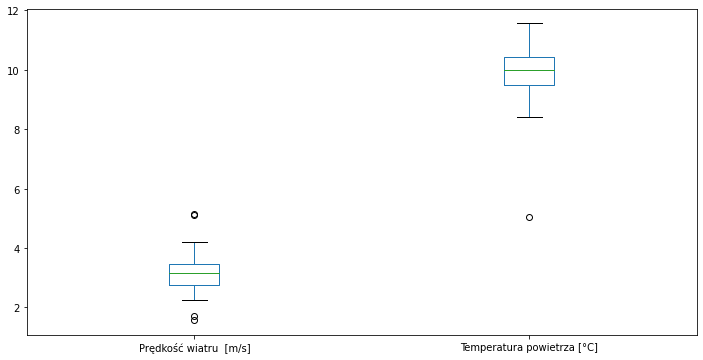

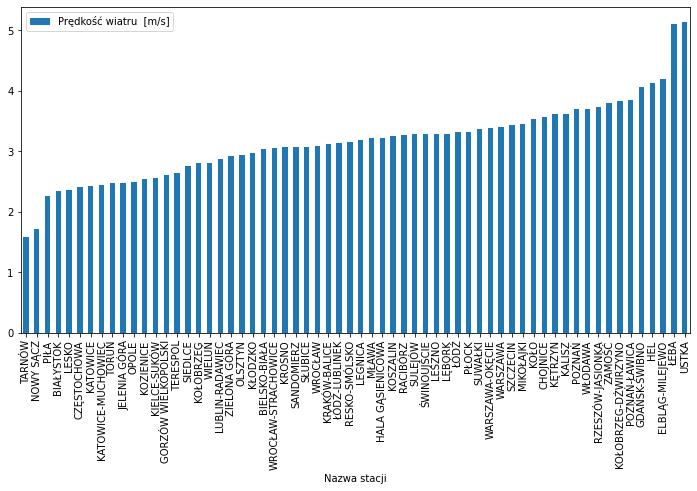

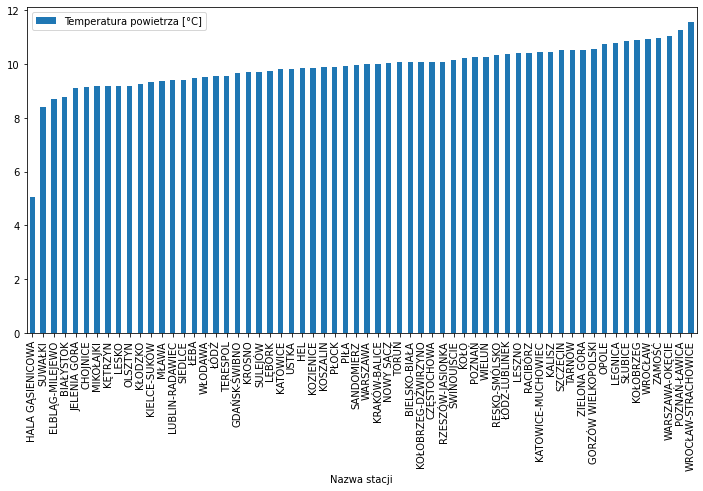

In [13]:
weatherByStation.plot(kind='box', figsize=(12,6))
weatherByStation = weatherByStation.sort_values('Prędkość wiatru  [m/s]')
weatherByStation[['Prędkość wiatru  [m/s]']].plot(kind='bar', figsize=(12,6))
weatherByStation = weatherByStation.sort_values('Temperatura powietrza [°C]')
weatherByStation[['Temperatura powietrza [°C]']].plot(kind='bar', figsize=(12,6))
# weatherByStation


In [14]:
def date_from_row(x):
    y=x['Rok']
    m=x['Miesiąc']
    d=x['Dzień']
    return date(y,m,d)

In [15]:
weatherDF['DataGodz'] = weatherDF.apply(lambda x: date_from_row(x), axis = 1)
weatherDF['DataGodz'] = pd.to_datetime(weatherDF['DataGodz']) 

weatherDF['DataGodz'] = weatherDF['DataGodz'] + weatherDF['Godzina'].apply(
   lambda x: relativedelta(hours=x)
)

D:\Programy\anaconda\lib\site-packages\pandas\core\arrays\datetimelike.py:1345: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized
  PerformanceWarning,


In [16]:
weatherAvg = weatherDF[
            ['Nazwa stacji',
           'Temperatura powietrza [°C]',
            'DataGodz']
         ].groupby('DataGodz',as_index=False).mean()

In [17]:
weatherAvg

,DataGodz,Temperatura powietrza [°C]
0,2014-01-01 00:00:00,0.321569
1,2014-01-01 01:00:00,0.252941
2,2014-01-01 02:00:00,0.282353
3,2014-01-01 03:00:00,0.345098
4,2014-01-01 04:00:00,0.435294
...,...,...
61363,2020-12-31 19:00:00,-0.229630
61364,2020-12-31 20:00:00,-0.379630
61365,2020-12-31 21:00:00,-0.511111
61366,2020-12-31 22:00:00,-0.666667


#### łączenie pogody z zapotrzebowaniem

In [94]:
dataAll = pd.merge(dataAll, weatherAvg, how='left',on='DataGodz')

#### petla godzinowa

In [95]:
models_num = 24*7 #168
my_models = [None] * models_num

In [77]:
# modelData2.where(modelData2['DataGodz'].hour==2)
# modelData2[dataAll['Godzina']==23]['Krajowe zapotrzebowanie na moc']
# dataAll.loc[(dataAll['Godzina']==24) & (dataAll['weekDayNum']==0)]#['Krajowe zapotrzebowanie na moc']

In [96]:
starttime = datetime.datetime.now()
print('start petli: ' +str(starttime))
for i in range(models_num):
    print('##### startuje dopasowanie modelu dla godziny: ' + str(i))
    my_models[i] = create_model(
        dataAll.loc[(dataAll['Godzina'] %24 ==i % 24) & 
                    (dataAll['weekDayNum']==int(i/24))]
        ['Krajowe zapotrzebowanie na moc']
        ,4
        ,regresor = dataAll.loc[(dataAll['Godzina'] %24 ==i % 24) & 
                    (dataAll['weekDayNum']==int(i/24))]
        [['Temperatura powietrza [°C]']]
    )
    print('##### Koniec dopasowania modelu dla godziny: ' + str(i))
    print('#####')
print('czas trwania calosci: ' +str(datetime.datetime.now()-starttime))

start petli: 2021-05-25 11:39:54.785227
##### startuje dopasowanie modelu dla godziny: 0


ValueError: zero-size array to reduction operation maximum which has no identity

In [79]:
import winsound
frequency = 1500  # Set Frequency To 2500 Hertz
duration = 3000  # Set Duration To 1000 ms == 1 second
winsound.Beep(frequency, duration)

In [80]:
test_start = '2019-04-01'
test_end = '2020-02-29'
weatherTest = weatherAvg[weatherAvg['DataGodz'].between(test_start, test_end)][['Temperatura powietrza [°C]']]


### Progrnozowanie

In [81]:
forecast_steps = int(2260/168)
forecasted_data=[None]*models_num
for i in range(models_num):
    forecasted_data[i] = my_models[i].forecast(forecast_steps, 
                                               exog = weatherTest[i:168*13:168])
print(weatherTest[0:168*13:168])

D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Pre

D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Pre

D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Pre

       Temperatura powietrza [°C]
45984                    2.212963
46152                    4.412963
46320                    2.429630
46488                    5.687037
46656                    9.116667
46824                    3.392593
46992                    7.561111
47160                   14.377778
47328                   13.594444
47496                   14.605556
47664                   15.996296
47832                   15.835185
48000                   14.514815


In [82]:
# combined_forecasted_data = [None] * forecast_steps * models_num
# for j in range(forecast_steps):
#     for i in range(models_num):
#         combined_forecasted_data[j * models_num + i] = forecasted_data[i].iloc[j]

In [83]:
combined_forecasted_data = [None] * forecast_steps * models_num
for j in range(forecast_steps):
    for i in range(1,models_num):
        combined_forecasted_data[j * models_num + i-1] = forecasted_data[i].iloc[j]
    combined_forecasted_data[j * models_num + models_num-1] = forecasted_data[0].iloc[j]
        

In [84]:
combined_forecasted_data = pd.Series(combined_forecasted_data)

In [85]:
combined_forecasted_data

0        4686.437212
1        2554.105864
2         523.675033
3       -1629.971315
4       -2444.283686
            ...     
2179    45460.504330
2180    45134.928265
2181    45013.405807
2182    44225.751948
2183    30418.203506
Length: 2184, dtype: float64

### Obliczanie błędu

In [86]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [87]:
test_data = combineData(test_start, test_end)['Krajowe zapotrzebowanie na moc']

In [88]:
test_data

0       15162.738
1       14675.575
2       14593.075
3       14671.838
4       15037.125
          ...    
8036    20608.925
8037    20036.225
8038    18958.488
8039    17730.888
8040    16650.150
Name: Krajowe zapotrzebowanie na moc, Length: 8041, dtype: float64

In [89]:
sample = 720#2160
mean_absolute_percentage_error(test_data.iloc[:sample], combined_forecasted_data.iloc[:sample])

45.237999562859436

In [90]:
print('czas trwania calosci: ' +str(datetime.datetime.now()-starttime))

czas trwania calosci: 0:03:00.062914


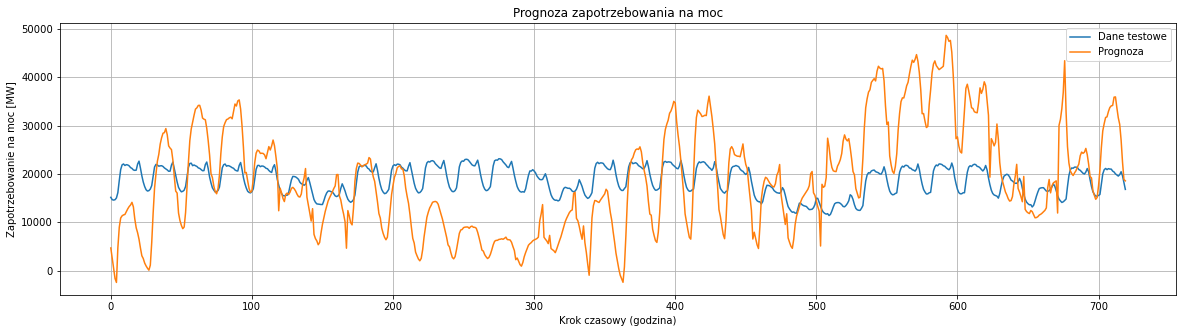

In [91]:
plt.figure(figsize=[20,5])
test_data.iloc[:sample].plot()
combined_forecasted_data.iloc[:sample].plot()
plt.legend(['Dane testowe', 'Prognoza'])
plt.grid()
plt.xlabel('Krok czasowy (godzina)')
plt.ylabel('Zapotrzebowanie na moc [MW]')
plt.title('Prognoza zapotrzebowania na moc')
plt.savefig('Prognoza zapotrzebowania na moc m168s4 z pogoda')